In [132]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math
from seaborn import heatmap
from matplotlib import transforms
from skimage import metrics

In [27]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [28]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [29]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [30]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [218]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [230]:
# Plots a given frequency bin of target, matched, and reference audio, along with its dynamic response historgram
def plotDynamics(tAudio, mAudio, rAudio, dynamicBins, plotBin):
    # frequency bin plotted in dB
    tdB = 20*np.log10(np.abs(tAudio["STFT"][plotBin,:]))
    mdB = 20*np.log10(np.abs(mAudio["STFT"][plotBin,:]))
    rdB = 20*np.log10(np.abs(rAudio["STFT"][plotBin,:]))

    # gets dynamic response historgram of target, matched, and reference
    # this needs to be changed to get the max and min across all 3
    tDynamicResponse, mDynamicResponse, rDynamicResponse = getDynamicResponse(tAudio["STFT"][plotBin,:], rAudio["STFT"][plotBin,:], dynamicBins, mFreqBin=mAudio["STFT"][plotBin,:])

    dB = (tdB, mdB, rdB)
    dynamicResponse = (tDynamicResponse, mDynamicResponse, rDynamicResponse)

    # plot
    fig, ax = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='col', figsize=(10*figScale, 5*figScale), gridspec_kw={'width_ratios': [8, 1]})
    
    for i in range(3):
        ax[i,0].plot(dB[i])
        
        tr = transforms.Affine2D().rotate_deg(90)
        reshape = np.flip(dynamicResponse[i].reshape(dynamicResponse[i].shape[0], 1))
        sns = heatmap(reshape, ax=ax[i,1], cmap="magma")
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,0].set_ylabel("Gain (dB)")
        ax[i,0].set_xlabel("Frame")
        fig.tight_layout(rect=[0, 0, .9, 1])
    
    # adjusts appearance
    for ax_i in ax:
        ax_i[0].label_outer()
    ax[0,0].set(title='Target')
    ax[1,0].set(title='Matched')
    ax[2,0].set(title='Reference')

In [232]:
# Function to calculate the dynamic response historgrams, used for calculating similarity of frequency bins. May optionally take matched audio, calculating 3 histograms (for vis purposes only)
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins, mFreqBin=None):
    # Convert to dB
    tdB = 20*np.log10(np.abs(tFreqBin))
    rdB = 20*np.log10(np.abs(rFreqBin))
    if(type(mFreqBin) == np.ndarray):
        mdB = 20*np.log10(np.abs(mFreqBin))

    # The minimum and maximum gain values across target and reference combined
    if(type(mFreqBin) != np.ndarray):
        dynamicRange = (min(min(tdB),min(rdB)), max(max(tdB),max(rdB)))
    else:
        dynamicRange = (min(min(tdB),min(rdB),min(mdB)), max(max(tdB),max(rdB),max(mdB)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tdB,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rdB,bins=dynamicBins,range=dynamicRange)[0]
    if(type(mFreqBin) == np.ndarray):
        mDynamicResponse = np.histogram(mdB,bins=dynamicBins,range=dynamicRange)[0]

    if(type(mFreqBin) != np.ndarray):
        return tDynamicResponse, rDynamicResponse
    else:
        return tDynamicResponse, mDynamicResponse, rDynamicResponse

def getSimilarity(tDynamicResponse, rDynamicResponse):
    tNormalised = tDynamicResponse / max(tDynamicResponse)
    rNormalised = rDynamicResponse / max(rDynamicResponse)
    
    ssim = ((metrics.structural_similarity(tNormalised, rNormalised, win_size=3, data_range=1))/2)+0.5

    return ssim

def match(tAudio, rAudio, dynamicBins):
    bin = 100
    tSlice = tAudio["STFT"][bin,:]
    rSlice = rAudio["STFT"][bin,:]
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
    similarity = getSimilarity(tDynamicResponse,rDynamicReponse)
    
    scaler = 20*np.log10(np.abs(rAudio["DFT"])) / 20*np.log10(np.abs(tAudio["DFT"]))
    return {"STFT":tAudio["STFT"]*scaler,"DFT":tAudio["DFT"]*scaler,"sampleRate":tAudio["sampleRate"]}

def dynamicMatching(tAudio,rAudio,dynamicBins, plotBin):
    tDynamicResponse, rDynamicReponse = getDynamicResponse(tAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    print("unmatched similarity:",getSimilarity(tDynamicResponse, rDynamicReponse))

    mAudio = match(tAudio, rAudio, dynamicBins)

    mDynamicResponse, rDynamicReponse = getDynamicResponse(mAudio["STFT"][plotBin,:],rAudio["STFT"][plotBin,:],dynamicBins)
    print("matched similarity:  ",getSimilarity(mDynamicResponse, rDynamicReponse))

    plotDynamics(tAudio, mAudio, rAudio, dynamicBins, plotBin)

    return mAudio


<h1>Execution</h1>

In [34]:
frameSize=2048
hopSize=512

figScale = 1

unmatched similarity: 0.48805704751710083
matched similarity:   0.5033600315424467


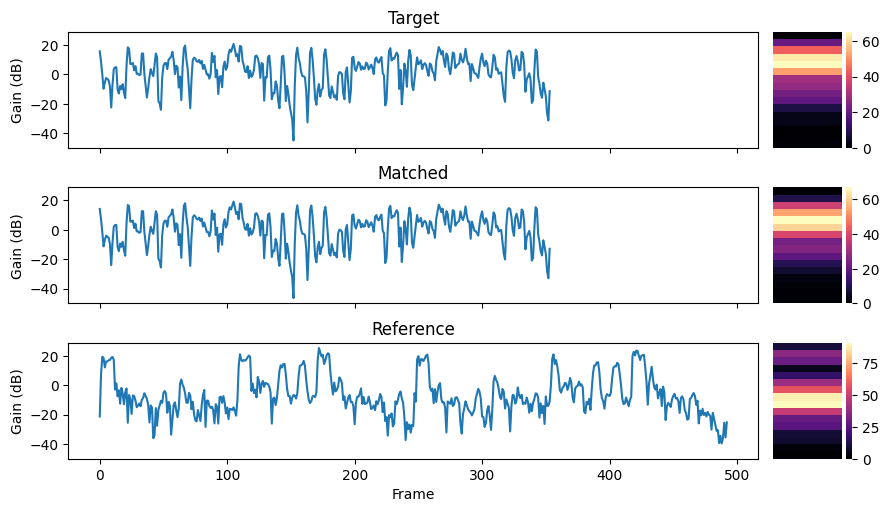

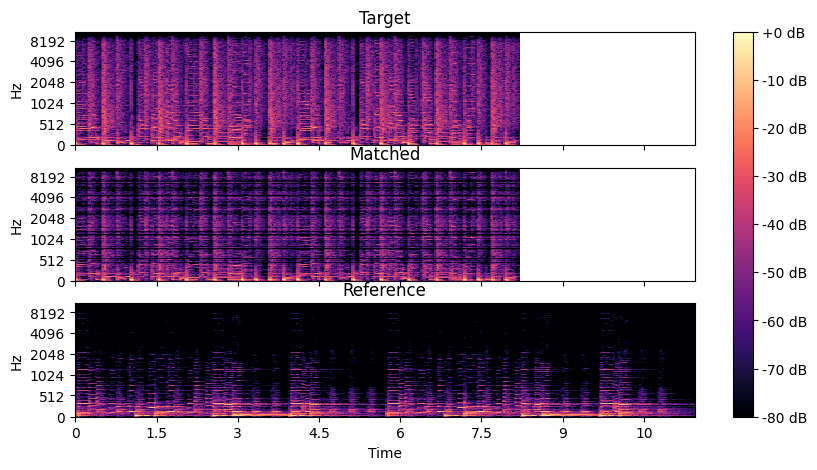

In [235]:
#tAudio, rAudio = importAudio(target="tone1.wav",reference="tone2loud.wav", output=False)
tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

mAudio = dynamicMatching(tAudio,rAudio,dynamicBins=16, plotBin=50)

#mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)



#dynamicMatching(mAudio,rAudio,dynamicBins=16)

plotSpectrogram(tAudio, mAudio, rAudio)

In [236]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference


In [75]:
import numpy as np
from numpy.linalg import norm

A = np.array([0,0,0,0,0,0,0,1])
B = np.array([0,0,0,0,0,1,0,0])
 
# cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))

print(cosine)

0.0


In [76]:
import numpy as np
from numpy.linalg import norm

A = np.array([0,0,0,0,0,0,0,1])
B = np.array([0,0,0,0,0,0,1,0])
 
# cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))

print(cosine)

0.0


In [131]:
from skimage import metrics
import numpy as np

arr1 = np.array([0, 0, 0, 1, 0, 0, 0.5])
arr2 = np.array([0, 0, 0, 0, 0, 0, 1])

arr3 = np.array([0, 0, 0, 0, 0, 0, 1])
arr4 = np.array([0, 0, 0, 0, 0, 0, 1])


ssim1 = metrics.structural_similarity(arr1, arr2, win_size=3, multichannel=False, data_range=1)
ssim2 = metrics.structural_similarity(arr3, arr4, win_size=3, multichannel=False, data_range=1)
print("Structural Similarity 1:", ssim1)
print("Structural Similarity 2:", ssim2)

Structural Similarity 1: 0.3280934596180887
Structural Similarity 2: 1.0


C:\Users\mrozi\AppData\Local\Temp\ipykernel_22284\1513902762.py:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim1 = metrics.structural_similarity(arr1, arr2, win_size=3, multichannel=False, data_range=1)
C:\Users\mrozi\AppData\Local\Temp\ipykernel_22284\1513902762.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim2 = metrics.structural_similarity(arr3, arr4, win_size=3, multichannel=False, data_range=1)


In [183]:
test = [1,2]
type(test)

list

In [241]:
db = 20*np.log10(50)

10**(db/20)

49.99999999999999